# Проверка результатов A/B-теста для интернет-магазина

## Описание проекта <a id="описание"></a>

**Заказчик:** Интернет-магазин "Ноунейм"

**Что исследуем:** Влияние какого-то изменения на сайте на конверсию и средний чек интернет-магазина

**Цель:** Определить, влияет ли изменение на выручку и стоит ли продолжать тест

**Задачи**:
1. Проанализировать результаты A/B-теста и сделать выводы
2. Приоритизировать гипотезы

**Данные:**
1. список гипотез с оценкой по методу (R)ICE
2. Данные о заказах за период проведения теста
3. Данные о визитах на сайт за период проведения теста

## Шаг 1. Изучение и предобработка данных <a id="Шаг_1"></a>
[К оглавлению](#оглавление)<br>
[К выводам по шагу](#conclusion1)

In [2]:
# импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import datetime as dt

plt.style.use('seaborn') 
sns.set(style="darkgrid")

pd.options.display.float_format = '{: .2f}'.format
pd.options.display.max_colwidth = -1

import warnings 
warnings.filterwarnings('ignore') 

hypos = pd.read_csv('/datasets/hypothesis.csv')

orders = pd.read_csv('/datasets/orders.csv')

visitors = pd.read_csv('/datasets/visitors.csv')

**Таблица Hypothesis** (информация о гипотезах; 5 столбцов):

1. **Hypothesis** — краткое описание гипотезы
2. **Reach** — охват пользователей по 10-балльной шкале;
3. **Impact** — влияние на пользователей по 10-балльной шкале;
4. **Confidence** — уверенность в гипотезе по 10-балльной шкале;
5. **Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

Чем больше значение Efforts, тем дороже проверка гипотезы.

In [3]:
# изучаем данные
hypos.info()
print('кол-во строк-дубликатов: ', hypos.duplicated().sum())
display(hypos.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
кол-во строк-дубликатов:  0


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


В таблице нет дубликатов и экстримальных значений. <br>
Типы данных в порядке.

**Таблица Orders** (информация о заказах и покупателях; 5 столбцов):

1. **transactionId** — идентификатор заказа
2. **visitorId** — идентификатор пользователя, совершившего заказ
3. **date** — дата, когда был совершён заказ
4. **revenue** — выручка заказа
5. **group** — группа A/B-теста, в которую попал заказ

In [4]:
# изучаем данные
orders.info()
print('кол-во строк-дубликатов: ', orders.duplicated().sum())
display(orders.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
кол-во строк-дубликатов:  0


,transactionId,visitorId,date,revenue,group
647,2180201337,1728743776,2019-08-26,9490,B
140,2774185760,975516572,2019-08-01,1190,B
315,1939633950,157579733,2019-08-19,2330,B
740,405281389,2108163459,2019-08-09,580,A
761,1109375840,2924874435,2019-08-07,990,A


В таблице нет дубликатов. <br>
Следует привести тип данных в столбце date к формату date.time.

In [5]:
orders['date'] = pd.to_datetime(orders['date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


**Таблица Visitors** (информация о посещениях и посетителях сайта; 3 столбца):

1. date — дата
2. group — группа A/B-теста
3. visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [6]:
# изучаем данные
visitors.info()
print('кол-во строк-дубликатов: ', visitors.duplicated().sum())
display(visitors.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
кол-во строк-дубликатов:  0


,date,group,visitors
30,2019-08-31,A,699
60,2019-08-30,B,490
45,2019-08-15,B,544
21,2019-08-22,A,609
52,2019-08-22,B,650


Дубликатов нет. <br>
Следует заменить тип данных в столбце с датой.

In [7]:
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Выводы <a id="conclusion1"></a>

1. Таблицы не содержат дубликатов и неадекватных значений.

2. В таблицах orders и visitors заменили тип данных у столбца date на datetime, чтобы с этим столбцом было удобнее работать.

### 1.1 Приоритизация гипотез

- [x] приоритизировать гипотезы с помощью метода ICE
- [x] приоритизировать гипотезы с помощью метода RICE
- [x] Объяснить, почему у одних и тех же гипотез получился разный приоритет

In [8]:
hypos['ICE'] = (hypos['Impact'] * hypos['Confidence']) / hypos['Efforts']
hypos.sort_values('ICE', ascending = False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Если следовать оценки по методу ICE, то в первую очередь следует оценить гипотезы с индексами 8, а затем 0 и 7.

Гипотезы с индексами 1, 5, 3 и 4 не стоит проверять, так как у них слишком низкая оценка. <br>
Такую оценку эти гипотезы получили, потому что слишком низкая уверенность (Confidence) в том, что трудозатраты (Efforts) и польза (Impact) оценены правильно.

In [9]:
hypos['RICE'] = (hypos['Reach'] * hypos['Impact'] * hypos['Confidence']) / hypos['Efforts']

hypos.sort_values('RICE', ascending = False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


Если следовать оценки по методу RICE, то в первую очередь следует оценить гипотезу с индексом 7, а затем 2, 0 и 6.

Гипотезы с индексами 8, 3, 1, 5 и 4 не стоит проверять, так как у них слишком низкая оценка. <br>
Такую оценку эти гипотезы получили из-за низкого охвата (в слачае 8 гипотезы) и из-за низкой уверенности (Confidence) в оценке по остальным параметрам (во всех остальных гипотезах).

#### Выводы

При оценке по обоим методам стоит отказаться от проверки гипотез с индексами 1, 3, 4 и 5.

Если следовать оценке RICE, то к этому списку добавляется гипотеза с индексом 8. <br>
Это происходит потому, что, несмотря на высокие оценки по другим параметрам, гипотетическое изменение охватит очень мало пользователей (Reach = 1). <br>
Оценка по методу ICE не учитывает этот параметр и поэтому ставит гипотезу с индексом 8 на первое место.

При оценке по методу ICE следует в первую очередь проверять гипотезы 8, 0 и 7. 

При оценке по RICE: 7, 2, 0 и 6.

Как видно, в RICE добавляются гипотезы 2 и 0 (и при этом снижается приоритет у гипотезы 0). <br>
Это происходит из-за влияния параметра Reach: он понижает приоритет тех гипотез, у которых низкий охват.

****

## Шаг 2. Анализ A/B-теста <a id="Шаг_2"></a>
[К оглавлению](#оглавление)<br>

Чек-лист чтобы ничего не забыть:
- [x] Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
- [x] Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
- [x] Постройте график относительного изменения кумулятивного среднего чека группы B к группе A.Сделайте выводы и предположения.
- [x] Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.
- [x] Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.
- [x] Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
- [x] Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
- [x] Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
- [x] Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
- [x] Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.
- [x] Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
- [x] Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.
- [x] Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

Прежде, чем приступить к построению графиков и расчету статистик, нам нужно создать датафрейм, в котором соберем куммулятивные данные.

In [10]:
# соберем все уникальные пары дат и групп теста
#далее мы используем этот датафрейм, чтобы посчитать кол-во заказов, пользователей и общую выручку накопленные на каждый день

datesGroups = orders[['date','group']].drop_duplicates() 
datesGroups

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


Далее на каждую дату из полученной таблицы соберем куммулятивные данные о заказах. <br>
Сделаем это так:
1. Получим строки таблицы orders, которые меньше или равны дате из новой таблицы и в которых указана соотвествующая группа (А/B)
2. Для каждого такого среза найдем общее кол-во заказов и посетителей, а также суммарную выручку, и припишем эти данные к максимальной дате в срезе (она совпадает с датой из таблицы datesGroups)
3. Отсортируем результат по дате и группе

В итоге мы получим такой датафрейм, в котором на каждый день будет указано количество пользователей, заказов и общая выручка, которые успели накопиться к этому дню.

In [11]:
ordersAggregated = (datesGroups
                     # Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups,
                     #а группа теста равна группе из datesGroups
                     .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                            # посчитаем нужные данные по полученному срезу
                            .agg({'date' : 'max',
                                  'group' : 'max',
                                  'transactionId' : pd.Series.nunique,
                                  'visitorId' : pd.Series.nunique,
                                  'revenue' : 'sum'}),
                            axis=1) # применим лямбда-функцию к каждой строке датафрейма
                     .sort_values(by=['date','group']) # отсортируем таблицу
                    )

ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Получили нужную таблицу.

Далее сделаем такую же, но по датафрейму с посетителями найдем суммарное кол-во посетителей в каждой группе на каждый день.

In [12]:
visitorsAggregated = (datesGroups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                             .agg({'date' : 'max',
                                   'group' : 'max',
                                   'visitors' : 'sum'}),
                             axis=1)
                      .sort_values(by=['date','group']))

visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Далее объединим обе таблицы в одну, посчитаем конверсию и сделаем срезы для разных групп.

In [13]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# посчитаем конверсию сайта (из посещения в покупку)
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData.query('group == "A"')

# отделяем данные по группе B
cumulativeDataB = cumulativeData.query('group == "B"')

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.03
1,2019-08-01,B,21,20,101217,713,0.03
2,2019-08-02,A,44,38,242401,1338,0.03
3,2019-08-02,B,45,43,266748,1294,0.03
4,2019-08-03,A,68,62,354874,1845,0.04


Таблица готова. Можно строить нужные графики и делать выводы.

### 2.1 Куммулятивная выручка по группам

In [14]:
# создаем датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData.query('group == "A"')[['date','revenue', 'orders']]

# создаем датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData.query('group == "B"')[['date','revenue', 'orders']]

cumulativeRevenueA.head()

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


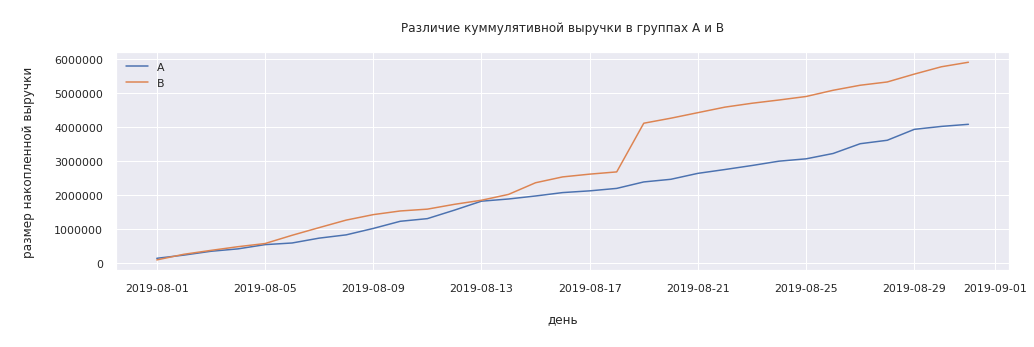

In [15]:
#визуализируем

plt.figure(figsize=(16, 4))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.title("\n" + 'Различие куммулятивной выручки в группах А и В' + "\n")
plt.ylabel("\n" + 'размер накопленной выручки' + "\n")
plt.xlabel("\n" + "день" + "\n")
plt.show()

Куммулятивная выручка в группе В, чаще всего была больше, чем в группе А.

Однако график группы В в одной точке сильно растет, что говорит о появлении дорогих заказов в середине августа. <br>
Из-за этого в следующие две недели выручка была значительно выше.

### 2.2 Куммулятивный средний чек по группам

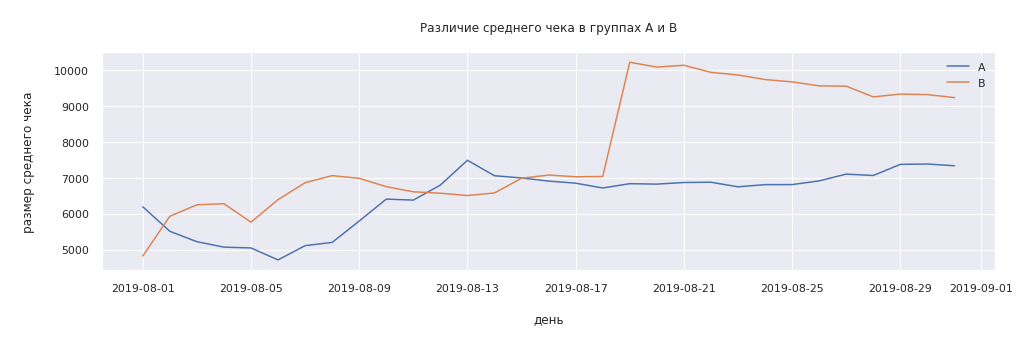

In [16]:
plt.figure(figsize=(16, 4))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.legend() 
plt.title("\n" + 'Различие среднего чека в группах А и В' + "\n")
plt.ylabel("\n" + 'размер среднего чека' + "\n")
plt.xlabel("\n" + "день" + "\n")
plt.show()

Из-за дорогих заказов в середине августа средний чек в группе В стал значительно выше, чем в группе А. <br>
Но затем график стабилизировался и размер среднего чека постепенно начал снижаться.

Пока непонятно, каким будет различие средних чеков, когда график группы В стабилизируется.

#### 2.2.1 Относительное изменение кумулятивного среднего чека группы B к группе A

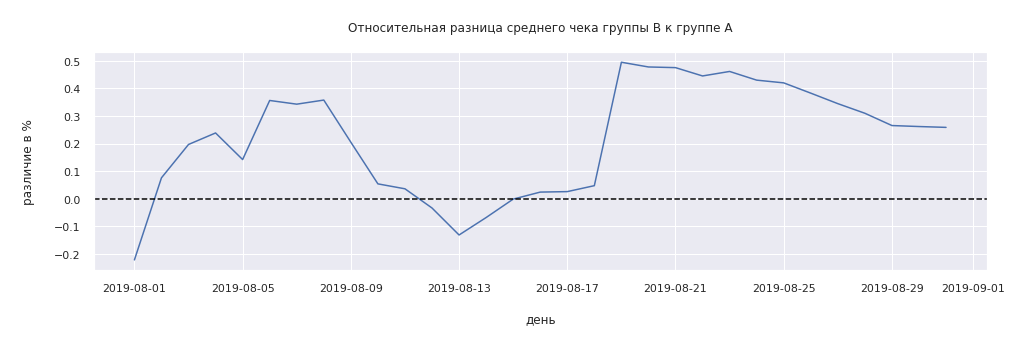

In [17]:
# собираем данные о куммулятивной выручки в группах в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   on='date',
                                                   how='left',
                                                   suffixes=['A', 'B'])


# визуализируем относительную разицу средних чеко в группах

# зададим размер графика
plt.figure(figsize=(16, 4))

# cтроим график отношения средних чеков
plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

# добавим описание графика
plt.title("\n" + 'Относительная разница среднего чека группы В к группе А' + "\n")
plt.ylabel("\n" + 'различие в %' + "\n")
plt.xlabel("\n" + "день" + "\n")
plt.show()

Относительная разница среднего чека была нестабильной на протяжении всего теста.

Из-за дорогих заказов в середине августа она сильно выросла и потом начала постепенно снижаться.

Пока график не стабилизировался делать выводы еще рано.

### 2.3 Куммулятивная конверсия по группам

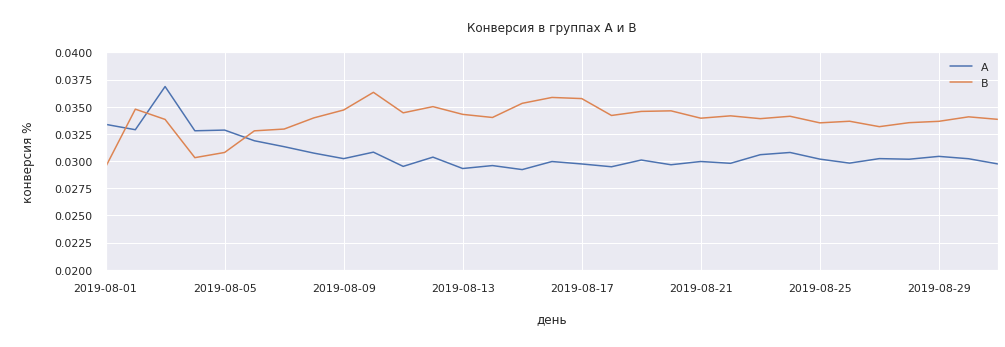

In [18]:
# зададим размер графика
plt.figure(figsize=(16, 4))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.axis(["2019-08-01", '2019-08-31', 0.02, 0.04])

# сопроводителя инфа к графику
plt.legend()
plt.title("\n" + 'Конверсия в группах А и В' + "\n")
plt.ylabel("\n" + 'конверсия %' + "\n")
plt.xlabel("\n" + "день" + "\n")
plt.show()

Оба графика стабилизировались на вторую неделю августа.

В группе В конверсия выше, чем в группе А.

#### 2.3.1 Относительное изменение кумулятивной конверсии группы B к группе A

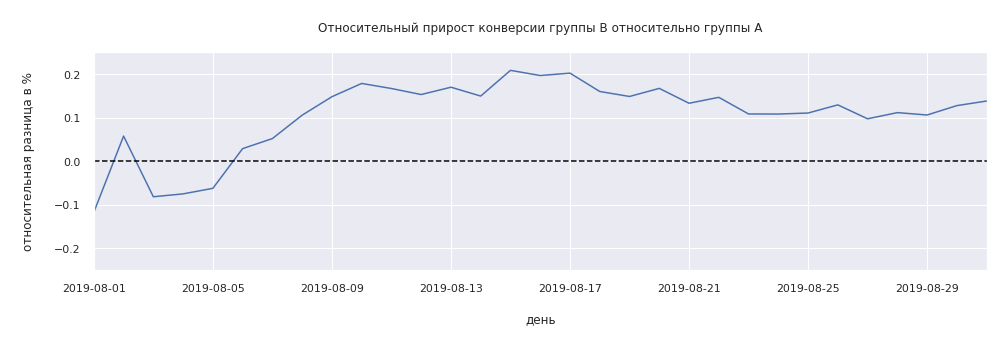

In [19]:
# соединим таблицы группы А и В, чтобы посчитать отношение конверсии группы В к группе А
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                               .merge(cumulativeDataB[['date','conversion']],
                                      left_on='date',
                                      right_on='date',
                                      how='left',
                                      suffixes=['A', 'B'])
                              )
# считаем отношение конверсии
mergedCumulativeConversions['convs_relation'] = (mergedCumulativeConversions['conversionB']
                                                 / mergedCumulativeConversions['conversionA']-1)

# зададим размер графика
plt.figure(figsize=(16, 4))

# построим график
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['convs_relation'])
plt.axis(["2019-08-01", '2019-08-31', -0.25, 0.25])
plt.axhline(y=0, color='black', linestyle='--')

# добавим инфы
plt.title("\n" + 'Относительный прирост конверсии группы B относительно группы A' + "\n")
plt.ylabel("\n" + 'относительная разница в %' + "\n")
plt.xlabel("\n" + "день" + "\n")
plt.show()

Здесь также видно, что с 9 августа относительная разница колебалась в промежутка от 1 до 2%.

### 2.4 Количество заказов по пользователям

In [20]:
# сгруппируем таблицу orders по пользователям и найдем кол-во заказов на каждого пользователя
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})

# переименуем столбцы
ordersByUsers.columns = ['userId','orders']

ordersByUsers.sort_values(by='orders',ascending=False).head()

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


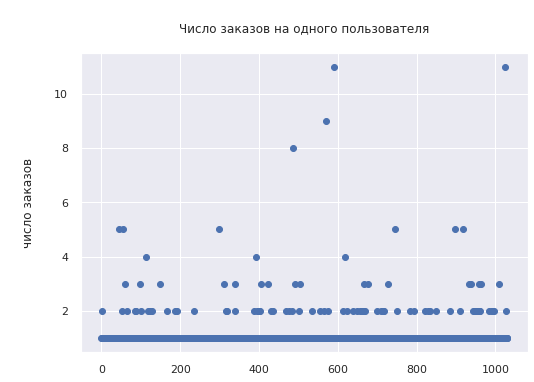


95% пользователей совершают не более 2 заказов

99% пользователей совершают не более 4 заказов


In [21]:
# построим график

# для оси Х создадим переменную - серию из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0,len(ordersByUsers)))

# визуализируем кол-во заказов по пользователям на точечном графике
plt.scatter(x_values, ordersByUsers['orders'])

plt.title("\n" + 'Число заказов на одного пользователя' + "\n")
plt.ylabel("\n" + 'число заказов' + "\n")
plt.show()

# 95 и 99 перцентили (метод квантилей работает также, как и перцентилей)
print("\n" + '95% пользователей совершают не более', round(ordersByUsers.orders.quantile(.95)), 'заказов')
print("\n" + '99% пользователей совершают не более', round(ordersByUsers.orders.quantile(.99)), 'заказов')

За верхнюю границу будем считать 4 заказа на человека.

Столько заказов совершают 99% всех пользователей.

### 2.5 Стоимость заказов

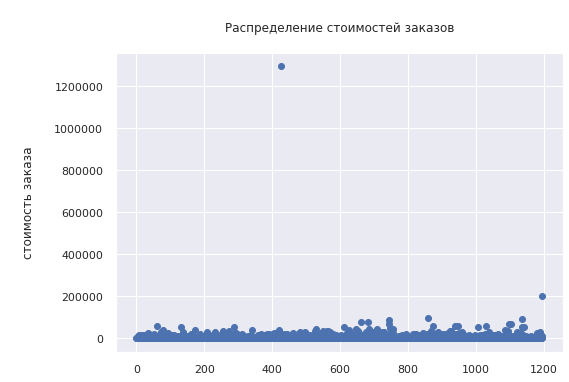


Не более 95% заказов стоят дороже, чем 28000

Не более 99% заказов стоят дороже, чем 58233


In [22]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'])

plt.title("\n" + 'Распределение стоимостей заказов' + "\n")
plt.ylabel("\n" + 'стоимость заказа' + "\n")
plt.show()

# 95 и 99 перцентили (метод квантилей работает также, как и перцентилей)
print("\n" + 'Не более 95% заказов стоят дороже, чем', round(orders.revenue.quantile(.95)))
print("\n" + 'Не более 99% заказов стоят дороже, чем', round(orders.revenue.quantile(.99)))

Разница между процентилями слишком большая: 4% совершают заказы до 58 тысяч.

За верхнюю границу установим значение в 30 000.

### 2.6 Различие конверсии в группах

Для начала нам понадобится очень большая таблица, в которой для каждой группы будет указано:
1. кол-во заказов за день
2. выручка за день
3. куммулятивное кол-во заказов на день
4. куммулятивная выручка на день
5. кол-во посетителей из группы в день
6. куммулятивное кол-во посетителей из группы на день

In [23]:
# найдем кол-во заказов в день в группе А
visitorsADaily = visitors.query('group == "A"')[['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsADaily.head()

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [24]:
# найдем коммулятивное кол-во посетителей на каждый день в группе А
visitorsACummulative = (visitorsADaily
                        .apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
                               .agg({'date' : 'max',
                                     'visitorsPerDateA':'sum'}),
                               axis=1)
                       )
                        
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsACummulative.head()

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [25]:
# то же самое повторим для группы В

visitorsBDaily = visitors.query('group == "B"')[['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = (visitorsBDaily
                        .apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
                               .agg({'date' : 'max',
                                     'visitorsPerDateB':'sum'}),
                               axis=1)
                       )
                        
visitorsBCummulative.columns = ['date', 'visitorsBCummulative']

In [26]:
# то же самое сделаем для заказов в обоих группах:
# найдем кол-во заказов за каждый день и куммулятивное кол-во на каждый день

# для группы А

# кол-во заказов в день
ordersADaily = (orders
                .query('group == "A"')[['date', 'transactionId', 'visitorId', 'revenue']]
                .groupby('date', as_index=False)
                .agg({'transactionId' : pd.Series.nunique,
                      'revenue' : 'sum'})
               )
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# куммулятивное кол-во заказов на день
ordersACummulative = (ordersADaily
                      .apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]
                             .agg({'date' : 'max',
                                   'ordersPerDateA' : 'sum',
                                   'revenuePerDateA' : 'sum'}),
                             axis=1)
                      .sort_values(by=['date'])
                     )
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

# для группы В

# кол-во заказов в день
ordersBDaily = (orders
                .query('group == "B"')[['date', 'transactionId', 'visitorId', 'revenue']]
                .groupby('date', as_index=False)
                .agg({'transactionId' : pd.Series.nunique,
                      'revenue' : 'sum'})
               )
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# куммулятивное кол-во заказов на день
ordersBCummulative = (ordersBDaily
                      .apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]
                             .agg({'date' : 'max',
                                   'ordersPerDateB' : 'sum',
                                   'revenuePerDateB' : 'sum'}),
                             axis=1)
                      .sort_values(by=['date'])
                     )
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [27]:
# соеденим все в одну большую таблицу
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsBCummulative
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


#### 2.6.1 Различие конверсии по "сырым" данным

Cоздадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. <br>
В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [28]:
# для группы А
ordersByUsersA = (orders
                  .query('group == "A"')
                  .groupby('visitorId', as_index=False)
                  .agg({'transactionId' : 'nunique'})
                 )

ordersByUsersA.columns = ['visitorId', 'orders']


# для группы В
ordersByUsersB = (orders
                  .query('group == "B"')
                  .groupby('visitorId', as_index=False)
                  .agg({'transactionId' : 'nunique'})
                 )

ordersByUsersB.columns = ['visitorId', 'orders'] 

ordersByUsersA.head()

,visitorId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. <br>
Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [29]:
# получим список с кол-вом заказов на каждого пользователя
# и добавим к нему список заказов, для пользователей, которые не делали заказ (в нем будут нули)
sampleA = (pd.concat([ordersByUsersA['orders'],  
                      pd.Series(0,
                                index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                                name='orders')],
                     axis=0)
          )


# то же самое для группы В
sampleB = (pd.concat([ordersByUsersB['orders'],
                      pd.Series(0,
                                index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                                name='orders')],
                     axis=0)
          )

SampleA и SampleB представляют собой список, в котором каждый элемент это число заказов для всех посетителей сайта (в том числе и ноль).

Получается, что кол-во элементов списка — это кол-во посетителей, а сумма всех элементов — это кол-во заказов.

Поэтому, чтобы получить конверсию в группе нужно просто применить метод mean() к семплу.

##### Проведем статистический тест

**Нулевая гипотеза (H0):** конверсии в группах не различаются

**Альтернативная гипотеза (H1):** конверсии различаются

**Уровень значимости:** 5%

In [30]:
print(
    "\n" + 'Конверсия группы В отличается от конверсии группы А на:',
      "{0:.3f}".format(
                      (data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())
                      / (data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1)
     )

print("\n" + 'Вероятность получить такое различие случайно составляет:',
      "{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))


Конверсия группы В отличается от конверсии группы А на: 0.138

Вероятность получить такое различие случайно составляет: 0.00840


Конверсия в группе В, выше чем в группе А, на 13%.

Вероятность получить такой результат случайно крайне мала — 0.8% <br>
Это значительно меньше, чем уровень значимости 5%. <br>

Значит, получить такое различие случайно почти невозможно. <br>
Следовательно, разница статистически значима: конверсия в группе В действительно выше

In [31]:
# Сделаем срез с очищенными данными.

usersWithManyOrders = pd.concat([ordersByUsersA.query('orders > 4')['visitorId'],
                                 ordersByUsersB.query('orders > 4')['visitorId']],
                                axis = 0)

usersWithExpensiveOrders = orders.query('revenue > 30000')['visitorId']
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0)
                 .drop_duplicates()
                 .sort_values()
                )

In [32]:
# создадим новые семплы по очищенным данным
# в семплы попадут только те пользователи, которые совершили не более 4 заказов и стоимость заказов была не выше 30 тысяч

sampleAFiltered = (pd.concat([ordersByUsersA
                              [np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
                              pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                                        name='orders')],
                             axis=0)
                  )

sampleBFiltered = (pd.concat([ordersByUsersB
                              [np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders']
                              ,pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders']))
                                         ,name='orders')],
                             axis=0) 
                  )

##### Проверим значимость различий по очищенным данным

**Нулевая гипотеза (H0):** конверсии в группах не различаются

**Альтернативная гипотеза (H1):** конверсии различаются

**Уровень значимости:** 5%

In [33]:
print(
    "\n" + 'Конверсия группы В отличается от конверсии группы А на:',
      "{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)
     )
     

print("\n" + 'Вероятность получить такое различие случайно составляет:',
          "{0:.5f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])
     )


Конверсия группы В отличается от конверсии группы А на: 0.144

Вероятность получить такое различие случайно составляет: 0.00942


В очищенных данных конверсия в группе В, выше чем в группе А, уже на 14%.

Вероятность получить такой результат случайно все также крайне мала — 0.9% <br>
Это тоже значительно меньше, чем уровень значимости 5%. <br>

Смело можно утверждать, что конверсия в группе В действительно выше, чем в группе А. <br>
Каким бы ни было тестируемое изменение, оно положительно влияет на конверсию.

### 2.7 Различия среднего чека в группах

#### 2.7.1 Различие среднего чека по "сырым" данным

**Нулевая гипотеза (H0):** средний чек в группах не различается

**Альтернативная гипотеза (H1):** размер среднего чека в группах различается

**Уровень значимости:** 5%

In [34]:
print("\n" + 'Относительное различие между средним чеком в группе В и в группе А:',
      "{0:.3f}".format(orders.query('group == "B"')['revenue'].mean() / orders.query('group == "A"')['revenue'].mean()-1))

print("\n" + 'Вероятность получить такое различие случайно:',
      "{0:.3f}".format(st.mannwhitneyu(orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'])[1]))


Относительное различие между средним чеком в группе В и в группе А: 0.259

Вероятность получить такое различие случайно: 0.365


Средний чек в группе В оказался выше на 26% процентов.

Однако такое различие мы могли получить случайно: p-value оказался гораздо выше, чем 5%.

Отклонить нулевую гипотезу нельзя: мы не знаем, действительно ли есть разница между размерами среднего чека в разных группах.

Посмотрим, какой будет результат на очищенных данных.

#### 2.7.2 Различие среднего чека по "очищенным" данным

**Нулевая гипотеза (H0):** средний чек в группах не различается

**Альтернативная гипотеза (H1):** размер среднего чека в группах различается

**Уровень значимости:** 5%

На очищенных данных оказалось, что средний чек в группе В ниже, чем в группе А.
<br> Однако, такое различие тоже можно получить случайно с вероятностью почти в 50%.
<br> В таком случае мы не можем отклонить нулевую гипотезу о том, что средние чеки в разных группах не различаются.

#### Выводы
1. Конверсия в группе В больше на 13-14% и это различие статистически значимо.
2. Нельзя утверждать, что размер среднего чека различается в разных группах: слишком высока вероятность получить различия случайно.

***

## Шаг 3. Принимаем решение по результатам A/B-теста <a id="Шаг_3"></a>
[К оглавлению](#оглавление)<br>

Чтобы принять решение еще раз посмотрим на графики и перечислим все результаты анализа.

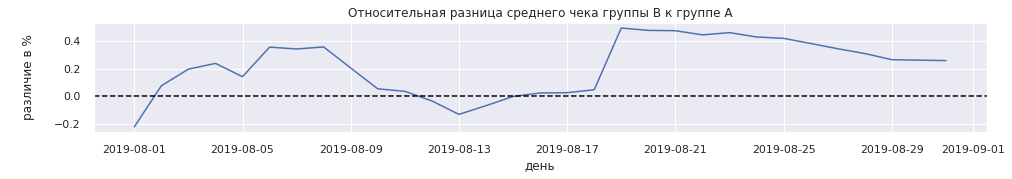

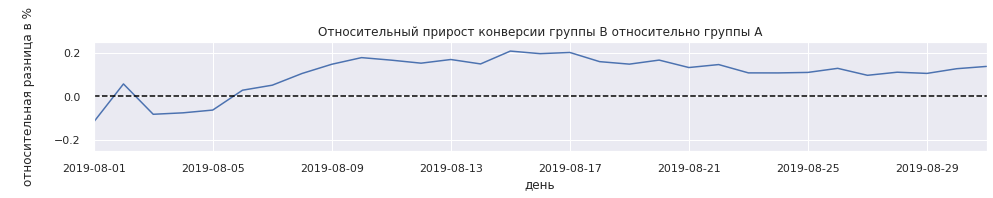

In [35]:
# зададим размер графика
plt.figure(figsize=(16, 2))

# cтроим график отношения средних чеков
plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1
        )

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Относительная разница среднего чека группы В к группе А')
plt.ylabel("\n" + 'различие в %' + "\n")
plt.xlabel("день")
plt.show()


# зададим размер графика
plt.figure(figsize=(16, 2))

# построим график
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['convs_relation'])
plt.axis(["2019-08-01", '2019-08-31', -0.25, 0.25])
plt.axhline(y=0, color='black', linestyle='--')

# добавим инфы
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.ylabel("\n" + 'относительная разница в %' + "\n")
plt.xlabel("день")
plt.show()

Имеющиеся факты:
+ Есть статистически значимое различие конверсий в разных группах: в группе В конверсия выше на 13-14%
+ По графику различия конверсии между группами видно, что конверсия группы B лучше, чем группы A, и она доходила даже до 20%

+ Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по очищенным данным
+ На графике различия среднего чека видны сильные колебания и постепенное снижение уровня различия в конце теста

Посмотрим на куммулятивную выручку в группах после очистки данных, чтобы убедиться, чтобы изменения в конверсии достаточно для увеличения выручки в группе В.

In [36]:
# сделаем срез нужных таблиц по адекватным данным: кол-во заказов меньше четырех и стоимость заказов меньше 30 тысяч

ordersAggregated_cleaned = (datesGroups
                     # Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups,
                     #а группа теста равна группе из datesGroups
                     .apply(lambda x: orders.query('visitorId not in @abnormalUsers')[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                            # посчитаем нужные данные по полученному срезу
                            .agg({'date' : 'max',
                                  'group' : 'max',
                                  'transactionId' : pd.Series.nunique,
                                  'visitorId' : pd.Series.nunique,
                                  'revenue' : 'sum'}),
                            axis=1) # применим лямбда-функцию к каждой строке датафрейма
                     .sort_values(by=['date','group']) # отсортируем таблицу
                    )

cumulativeData_cleaned = ordersAggregated_cleaned.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
#cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# посчитаем конверсию сайта (из посещения в покупку)
cumulativeData_cleaned['conversion'] = cumulativeData_cleaned['transactionId']/cumulativeData_cleaned['visitorId']

# создаем датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA_cleaned = cumulativeData_cleaned.query('group == "A"')[['date','revenue', 'transactionId']]

# создаем датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB_cleaned = cumulativeData_cleaned.query('group == "B"')[['date','revenue', 'transactionId']]

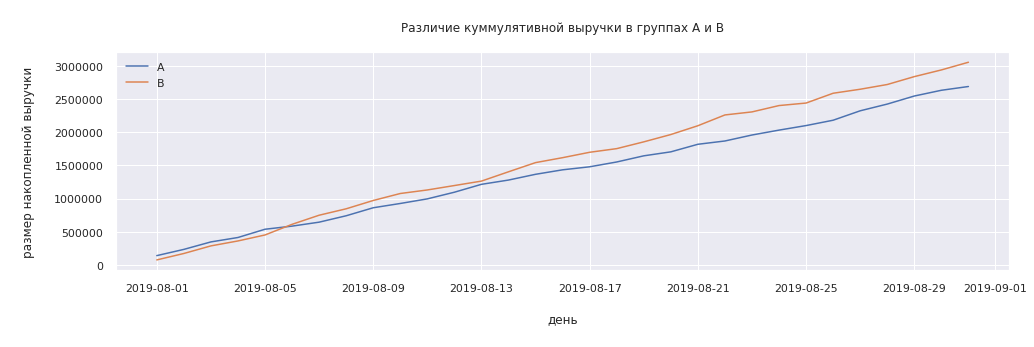

In [37]:
#визуализируем

plt.figure(figsize=(16, 4))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA_cleaned['date'], cumulativeRevenueA_cleaned['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB_cleaned['date'], cumulativeRevenueB_cleaned['revenue'], label='B')

plt.legend()
plt.title("\n" + 'Различие куммулятивной выручки в группах А и В' + "\n")
plt.ylabel("\n" + 'размер накопленной выручки' + "\n")
plt.xlabel("\n" + "день" + "\n")
plt.show()

На графике видно, что с момента, когда конверсия в группе В стала выше (после 5 августа), куммулятивная выручка в этой группе стала выше, чем в группе А, и стабильно оставалось такой на протяжении всего теста.

Значит, увеличение конверсии повлияло на кол-во заказов и, следовательно, на выручку.

### Вывод: что делать с А/В-тестом?

Выручка зависит от кол-ва покупателей и среднего чека. <br>
Кол-во покупателей зависит от кол-ва посетителей и конверсии в заказ.

В тесте мы не увидели статистически значимой разницы между средним чеком в группах А и В. <br>
Однако мы зафиксировали значимую разницу в конверсиях между группами: в группе В конверсия выше.

Это значит, что при одинаковых средних чеках группа В приносит больше выручки, чем группа А, за счет большего кол-ва покупателей (пользователей сделавших заказ).

Следовательно, тестируемое изменение поможет интернет-магазину увеличить выручку.

А/В-тест следует остановить и зафиксировать победу группы В.

### Какие гипотезы стоит еще протестировать?

При приоритизации гипотез следует использовать метод RICE, так как он учитывает охват пользователей, которые заметят изменения. <br>
По оценке метода следует проверить гипотезы с индексами 7, 2, 0 и 6. 

Метод ICE также предлагает проверить 8 гипотезу, но у неё слишком узкий охват. <br>
Возможно, следует точнее оценить эту гипотезу и принять решение о её проверке.

### На что еще обратить внимание?

99% заказов в интернет-магазине стоят до 59 тысяч рублей. <br>
Однако в  выгрузке попадались заказы от 60 до 1,2 млн рублей. <br>
Стоит разобраться: технические ли это ошибки, или действительно кто-то совершал заказы дороже 60 тысяч.